# Oracle Machine Learning Modeling

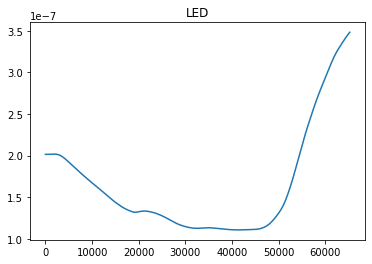

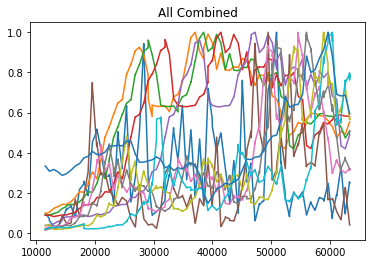

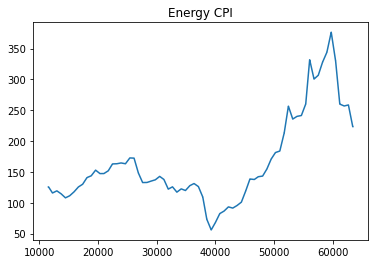

In [1463]:
# Read in data
from math import log
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from smoothing_function import ExponentialMovingAverage, HullMovingAverage

btc_diff = pd.read_csv('data/btc_diff.csv')
btc_price = pd.read_csv('data/btc_price.csv')
btc_per_block = pd.read_csv('data/btc_per_block.csv')
energy_cpi = pd.read_csv('data/energy_cpi.csv', skip_blank_lines=False)

# Multiply btc_price and btc_per_block into a new df
btc_issuance = btc_price['btc_price'] * btc_per_block['btc_per_block']

# Take Koomey's law and apply it to btc_diff
koomey_period_in_hours = 30*24*16
# x.name is the row number
btc_kdiff = btc_diff.apply(lambda x: x['btc_diff'] / (2 ** (1 + ((x.name+1) / koomey_period_in_hours))), axis=1)
ticks = btc_diff.apply(lambda x: x.name, axis=1)

# Apply EMA to btc_issuance
price_smoothing_factor = 30*24*18
price_ema = ExponentialMovingAverage(price_smoothing_factor)
btc_issuance_ema = btc_issuance.apply(lambda x: price_ema.apply_smoothing(x))

# plt.plot(btc_issuance)
# plt.title("BTC Issuance (USD)")
# plt.show()
# plt.title("BTC Issuance EMA Smoothed")
# plt.plot(btc_issuance_ema)
# plt.show()

# Apply HMA + EMA to btc_kdiff
kdiff_smoothing_factor = 30*24*8
kdiff_hma = HullMovingAverage(kdiff_smoothing_factor)
btc_kdiff_hma = btc_kdiff.apply(lambda x: kdiff_hma.apply_smoothing(x))

# Apply EMA to btc_kdiff
kdiff_ema = ExponentialMovingAverage(price_smoothing_factor)
btc_kdiff_ema = btc_kdiff.apply(lambda x: kdiff_ema.apply_smoothing(x))

# Create a dataframe with the max btc_diff and btc_price seen thus far
btc_diff_max = btc_diff.cummax()
btc_price_max = btc_price.cummax() 

# Create log of diff and price
btc_kdiff_log = np.log2(btc_kdiff)
btc_price_log = np.log2(btc_price)

led = btc_issuance_ema / btc_kdiff_hma
led_ema = ExponentialMovingAverage(price_smoothing_factor)
led_ema_result = led.apply(lambda x: led_ema.apply_smoothing(x))
plt.plot(led_ema_result)
plt.title("LED")
plt.show()

# Create dataframes with lagged version of the original data
def buildLaggedFeatures(df, num_lags, lag_gap_in_hours):
    """
    Builds a new dataframe containing lagged values of the features in the original dataframe.
    """
    df_result = pd.DataFrame()
    for lag in range(0, num_lags + 1):
        lag_in_hours = lag_gap_in_hours*(2**lag)
        df_result[f'value_lag_{lag}'] = df.shift(lag_in_hours)
    return df_result

num_lags = 3
lag_gap_in_hours = int(30*24*2)
max_lag = lag_gap_in_hours*(2**(num_lags))
btc_issuance_lags = buildLaggedFeatures(btc_issuance, num_lags, lag_gap_in_hours)
btc_kdiff_lags = buildLaggedFeatures(btc_kdiff, num_lags, lag_gap_in_hours)

# Create dataframe with aggregated stats of original data
def buildAggregatedFeatures(df, period_in_hours):
    """
    Builds a new dataframe containing aggregated values of the features in the original dataframe.
    """
    df_result = pd.DataFrame()
    df_result['std'] = df.rolling(period_in_hours).std()
    # df_result['med'] = df.rolling(period_in_hours).median()
    # df_result['mean'] = df.rolling(period_in_hours).mean()
    return df_result

num_periods = 1
stats_period_in_hours = int(30*24*1.3)
max_lag = max(max_lag, stats_period_in_hours)
btc_issuance_stats = buildAggregatedFeatures(btc_issuance, stats_period_in_hours)
btc_kdiff_stats = buildAggregatedFeatures(btc_kdiff, stats_period_in_hours)

# Join data into a single df by row number
df = pd.concat([btc_kdiff_stats, btc_kdiff_lags, btc_issuance_stats, btc_issuance_lags, energy_cpi], axis=1)
  
# Allow the smoothing factors to take effect
# max_lag = max(max_lag, price_smoothing_factor)
df = df.iloc[max_lag:]

# Drop NaNs
df = df.dropna()
df_normalized = df / df.max()
plt.title("All Combined")
plt.plot(df_normalized)
plt.show()
X = df.drop(['energy_cpi'], axis=1)
y = df['energy_cpi']

plt.plot(y)
plt.title("Energy CPI")
plt.show()


In [1464]:
#Split into test and training sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False)

## Linear Regression

In [1465]:
# Train model
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

y_lr_train_pred = lr.predict(X_train)
y_lr_test_pred = lr.predict(X_test)
coef = lr.coef_
print (coef)

[-4.22558597e-10 -8.48422135e-12  3.21450444e-13 -8.06933526e-11
 -7.18787412e-11  5.57083340e-04  1.67655985e-04  2.19917706e-04
  2.43013425e-04  3.68512496e-04]


In [1466]:
# Measure model peplormance
from sklearn.metrics import mean_squared_error, r2_score

lr_train_mse = mean_squared_error(y_train, y_lr_train_pred)
lr_train_r2 = r2_score(y_train, y_lr_train_pred)
lr_test_mse = mean_squared_error(y_test, y_lr_test_pred)
lr_test_r2 = r2_score(y_test, y_lr_test_pred)

corr_matrix = numpy.corrcoef(y_test, y_lr_test_pred)
corr = corr_matrix[0,1]
pearson_corr = corr**2


# Print results
lr_results = pd.DataFrame(['Linear regression',lr_train_mse, lr_train_r2, lr_test_mse, lr_test_r2, pearson_corr]).transpose()
lr_results.columns = ['Method','Training MSE','Training R2','Test MSE','Test R2', 'Pearson R2']
print(lr_results)

              Method Training MSE Training R2 Test MSE  Test R2 Pearson R2
0  Linear regression      288.646    0.766997  737.596  0.64509   0.660136


## Random Forest Model

In [1467]:
# Use Random Forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_depth=2, random_state=42)
rf.fit(X_train, y_train)

y_rf_train_pred = rf.predict(X_train)
y_rf_test_pred = rf.predict(X_test)

In [1468]:
from sklearn.metrics import mean_squared_error, r2_score

rf_train_mse = mean_squared_error(y_train, y_rf_train_pred)
rf_train_r2 = r2_score(y_train, y_rf_train_pred)
rf_test_mse = mean_squared_error(y_test, y_rf_test_pred)
rf_test_r2 = r2_score(y_test, y_rf_test_pred)

corr_matrix = numpy.corrcoef(y_test, y_rf_test_pred)
corr = corr_matrix[0,1]
pearson_corr = corr**2

# Print results
rf_results = pd.DataFrame(['Random forest',rf_train_mse, rf_train_r2, rf_test_mse, rf_test_r2, pearson_corr]).transpose()
rf_results.columns = ['Method','Training MSE','Training R2','Test MSE','Test R2', 'Pearson R2']
print(rf_results)

          Method Training MSE Training R2 Test MSE  Test R2 Pearson R2
0  Random forest      401.119    0.676206   8317.1 -3.00195   0.286897


## Polynomial Regression

In [1469]:
# Use Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
# Create and fit the linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_poly, y_train)

X_test_poly = poly.fit_transform(X_test)
# Evaluate the model using the test data
y_pl_train_pred = lin_reg.predict(X_train_poly)
y_pl_test_pred = lin_reg.predict(X_test_poly)

In [1470]:
from sklearn.metrics import mean_squared_error, r2_score

pl_train_mse = mean_squared_error(y_train, y_pl_train_pred)
pl_train_r2 = r2_score(y_train, y_pl_train_pred)
pl_test_mse = mean_squared_error(y_test, y_pl_test_pred)
pl_test_r2 = r2_score(y_test, y_pl_test_pred)

corr_matrix = numpy.corrcoef(y_test, y_pl_test_pred)
corr = corr_matrix[0,1]
pearson_corr = corr**2

# Print results
pl_results = pd.DataFrame(['Polynomial Regression',pl_train_mse, pl_train_r2, pl_test_mse, pl_test_r2, pearson_corr]).transpose()
pl_results.columns = ['Method','Training MSE','Training R2','Test MSE','Test R2', 'Pearson R2']
print(pl_results)

                  Method Training MSE Training R2 Test MSE  Test R2 Pearson R2
0  Polynomial Regression      133.876    0.891932   406426 -194.561   0.658792


## Support Vector Machine

In [1471]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# Scale the features for better performance with SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [1472]:
# Train the SVM model using the Radial Basis Function (RBF) kernel
svm_model = SVR(kernel='rbf', C=1e3, gamma=0.1)
svm_model.fit(X_train_scaled, y_train)

# Make predictions using the testing data
y_svm_train_pred = svm_model.predict(X_train_scaled)
y_svm_test_pred = svm_model.predict(X_test_scaled)


In [1473]:
from sklearn.metrics import mean_squared_error, r2_score

svm_train_mse = mean_squared_error(y_train, y_svm_train_pred)
svm_train_r2 = r2_score(y_train, y_svm_train_pred)
svm_test_mse = mean_squared_error(y_test, y_svm_test_pred)
svm_test_r2 = r2_score(y_test, y_svm_test_pred)

corr_matrix = numpy.corrcoef(y_test, y_svm_test_pred)
corr = corr_matrix[0,1]
pearson_corr = corr**2

# Print results
svm_results = pd.DataFrame(['Support Vector Machine',svm_train_mse, svm_train_r2, svm_test_mse, svm_test_r2, pearson_corr]).transpose()
svm_results.columns = ['Method','Training MSE','Training R2','Test MSE','Test R2', 'Pearson R2']
print(svm_results)

                   Method Training MSE Training R2 Test MSE Test R2 Pearson R2
0  Support Vector Machine     0.319607    0.999742  12909.5 -5.2117  0.0358311


## Multi-Layer Perceptron

In [1474]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [1475]:
# Train the MLP model
mlp_model = MLPRegressor(max_iter=500, random_state=42)
mlp_model.fit(X_train_scaled, y_train)

# Make predictions using the testing data
y_mlp_train_pred = mlp_model.predict(X_train_scaled)
y_mlp_test_pred = mlp_model.predict(X_test_scaled)


/home/cadder/.pyenv/versions/cadCAD/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [1476]:
from sklearn.metrics import mean_squared_error, r2_score

mlp_train_mse = mean_squared_error(y_train, y_mlp_train_pred)
mlp_train_r2 = r2_score(y_train, y_mlp_train_pred)
mlp_test_mse = mean_squared_error(y_test, y_mlp_test_pred)
mlp_test_r2 = r2_score(y_test, y_mlp_test_pred)

corr_matrix = numpy.corrcoef(y_test, y_mlp_test_pred)
corr = corr_matrix[0,1]
pearson_corr = corr**2

# Print results
mlp_results = pd.DataFrame(['Multi-Layer Perceptron',mlp_train_mse, mlp_train_r2, mlp_test_mse, mlp_test_r2, pearson_corr]).transpose()
mlp_results.columns = ['Method','Training MSE','Training R2','Test MSE','Test R2', 'Pearson R2']
print(mlp_results)

                   Method Training MSE Training R2 Test MSE Test R2 Pearson R2
0  Multi-Layer Perceptron      67.4788    0.945529  8047.03  -2.872  0.0266293


## Display Results

In [1477]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results(y_train, y_train_pred, y_test, y_test_pred, title):
    fig, ax = plt.subplots()
    # Scatter plot of true test labels
    ax.scatter(y_train, y_train_pred, color='blue', marker='o', label='Training predictions')

    # Scatter plot of predicted labels
    ax.scatter(y_test, y_test_pred, color='red', marker='x', label='Test predictions')

    # Customize the plot
    ax.set_title(title)

    # Create the line of best fit
    actual_values = np.concatenate((y_train, y_test))
    pred_values = np.concatenate((y_train_pred, y_test_pred))
    z = np.polyfit(actual_values, pred_values, 1)
    p = np.poly1d(z)
    line_x = np.linspace(np.min(actual_values), np.max(pred_values), 100)
    line_y = np.polyval(p, line_x)
    plt.plot(line_x, line_y, color='green')

    ax.set_xlabel('Actual Energy CPI')
    ax.set_ylabel('Predicted Energy CPI')
    ax.legend()

    # Show the plot
    plt.show()

                   Method Training MSE Training R2 Test MSE  Test R2  \
0       Linear regression      288.646    0.766997  737.596  0.64509   
0           Random forest      401.119    0.676206   8317.1 -3.00195   
0   Polynomial Regression      133.876    0.891932   406426 -194.561   
0  Support Vector Machine     0.319607    0.999742  12909.5  -5.2117   
0  Multi-Layer Perceptron      67.4788    0.945529  8047.03   -2.872   

  Pearson R2  
0   0.660136  
0   0.286897  
0   0.658792  
0  0.0358311  
0  0.0266293  


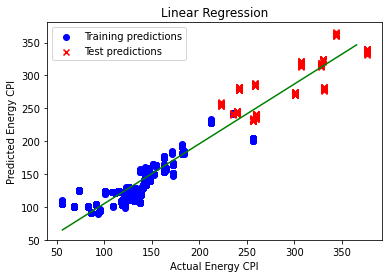

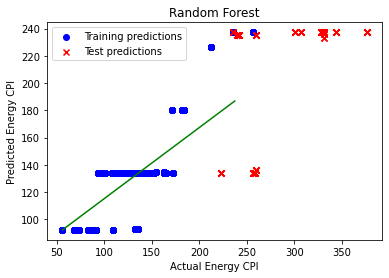

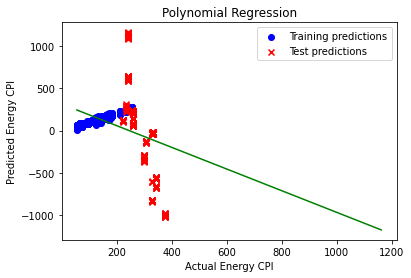

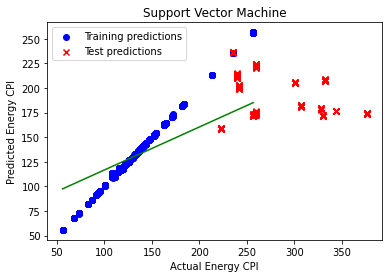

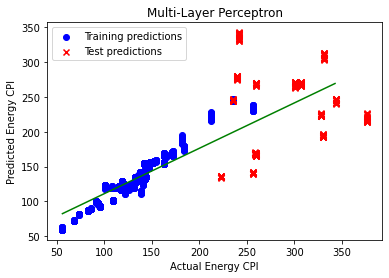

In [1478]:
print(pd.concat([lr_results, rf_results, pl_results, svm_results, mlp_results]))

plot_results(y_train, y_lr_train_pred, y_test, y_lr_test_pred, 'Linear Regression')
plot_results(y_train, y_rf_train_pred, y_test, y_rf_test_pred, 'Random Forest')
plot_results(y_train, y_pl_train_pred, y_test, y_pl_test_pred, 'Polynomial Regression')
plot_results(y_train, y_svm_train_pred, y_test, y_svm_test_pred, 'Support Vector Machine')
plot_results(y_train, y_mlp_train_pred, y_test, y_mlp_test_pred, 'Multi-Layer Perceptron')